In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from encodec import EncodecModel
from encodec.msstftd import MultiScaleSTFTDiscriminator
import encodec.customAudioDataset as data
from encodec.losses import total_loss, disc_loss
from encodec.utils import convert_audio, save_audio
from encodec.customAudioDataset import collate_fn

In [2]:
num_epochs = 30
batch_size = 2
sample_rate = 24000
learning_rate = 0.01
dataset_path = './dataset'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
dataset = data.CustomAudioDataset(dataset_folder=dataset_path, n_samples=50, sample_rate=sample_rate, tensor_cut=24000)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [4]:
model = EncodecModel._get_model(target_bandwidths=[6], 
                                sample_rate=sample_rate, 
                                channels=1, causal=False, audio_normalize=True, segment=1.0).to(device)

disc = MultiScaleSTFTDiscriminator(filters=32).to(device)

In [5]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.8, 0.99))
optimizer_disc = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.8, 0.99))

In [6]:
losses = {'loss_g': [], 'loss_w': [], 'loss_disc': []}

def train(n_epocs, model, disc, data_loader, optimizer, optimizer_disc):
    def adjust_learning_rate(optimizer, epoch):
        if epoch % 100 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        
    def train_one_step(epoch):
        epoch_loss_g = 0.0
        epoch_loss_w = 0.0
        epoch_loss_disc = 0.0
        for i, input_wav in enumerate(data_loader):
            input_wav = input_wav.contiguous().to(device)
            optimizer.zero_grad()            
            optimizer_disc.zero_grad()  
            model.zero_grad()
            disc.zero_grad()
            
            output_wav, loss_w = model(input_wav)
            logits_real, fmap_real = disc(input_wav)
            logits_fake, fmap_fake = disc(output_wav)
                
            losses_g = total_loss(fmap_real, logits_fake, fmap_fake, input_wav, output_wav, sample_rate, device)
            loss_g = 3 * losses_g['l_g'] + 3 * losses_g['l_feat'] + losses_g['l_t'] / 10 + losses_g['l_f']
            
            logits_real, _ = disc(input_wav)
            logits_fake, _ = disc(output_wav.detach())  
            loss_disc = disc_loss(logits_real, logits_fake)
            
            loss_w.backward(retain_graph=True)
            loss_g.backward()
            loss_disc.backward()
            optimizer.step()
            optimizer_disc.step()
            
            epoch_loss_g += loss_g.item()   
            epoch_loss_w += loss_w.item()   
            epoch_loss_disc += loss_disc.item()
            
        epoch_loss_g /= len(data_loader)    
        epoch_loss_w /= len(data_loader)
        epoch_loss_disc /= len(data_loader)
            
        losses['loss_g'].append(epoch_loss_g)
        losses['loss_w'].append(epoch_loss_w)
        losses['loss_disc'].append(epoch_loss_disc)
            
        # if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss_g: {epoch_loss_g:.4f} | Loss_w: {epoch_loss_w:.4f} | Loss_disc: {epoch_loss_disc:.4f}')
    
    model.train()
    disc.train()
    for epoch in range(n_epocs):
        train_one_step(epoch)
        # adjust_learning_rate(optimizer, epoch)
        # adjust_learning_rate(optimizer_disc, epoch)
     

In [7]:
train(num_epochs, model, disc, data_loader, optimizer, optimizer_disc)

c:\Projects\audio-test\encodec\audio_to_mel.py:17: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=n_mel_banks, fmin=mel_fmin, fmax=mel_fmax)


Epoch 0 | Loss_g: 4.5053 | Loss_w: 0.2422 | Loss_disc: 3.5027
Epoch 1 | Loss_g: 3.9342 | Loss_w: 0.0001 | Loss_disc: 2.1590
Epoch 2 | Loss_g: 3.9794 | Loss_w: 0.0000 | Loss_disc: 2.1693
Epoch 3 | Loss_g: 4.1839 | Loss_w: 0.0000 | Loss_disc: 2.1417
Epoch 4 | Loss_g: 4.1786 | Loss_w: 0.0000 | Loss_disc: 2.4841
Epoch 5 | Loss_g: 4.1989 | Loss_w: 0.0000 | Loss_disc: 2.0387
Epoch 6 | Loss_g: 3.9871 | Loss_w: 0.0000 | Loss_disc: 2.0199
Epoch 7 | Loss_g: 4.0559 | Loss_w: 0.0000 | Loss_disc: 2.0206
Epoch 8 | Loss_g: 4.0433 | Loss_w: 0.0000 | Loss_disc: 2.0329
Epoch 9 | Loss_g: 33.8569 | Loss_w: 0.0000 | Loss_disc: 84.9182
Epoch 10 | Loss_g: 9.1494 | Loss_w: 0.0000 | Loss_disc: 22.4654
Epoch 11 | Loss_g: 5.1429 | Loss_w: 0.0000 | Loss_disc: 5.3235
Epoch 12 | Loss_g: 4.3415 | Loss_w: 0.0000 | Loss_disc: 2.5694
Epoch 13 | Loss_g: 4.0936 | Loss_w: 0.0000 | Loss_disc: 2.2122
Epoch 14 | Loss_g: 4.2107 | Loss_w: 0.0000 | Loss_disc: 2.1059
Epoch 15 | Loss_g: 4.1526 | Loss_w: 0.0000 | Loss_disc: 2.0735

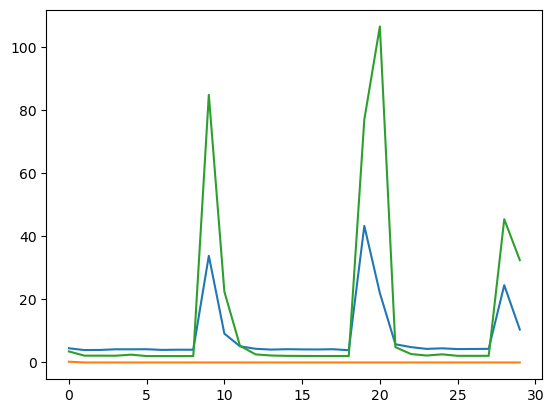

In [8]:
plt.plot(losses['loss_g'], label='Loss_g')
plt.plot(losses['loss_w'], label='Loss_w')
plt.plot(losses['loss_disc'], label='Loss_disc')

In [9]:
input = next(iter(data_loader)).to(device)

In [10]:
model.eval()
out = model.decode(model.encode(input))

In [11]:
save_audio(convert_audio(input[0].cpu(), sample_rate, sample_rate, 1), 'input.wav', sample_rate, True)